# ANALYSE SENTIMENTALE DE TEXTE  AVEC BERT

In [1]:
%%capture
!pip install -q datasets evaluate transformers[sentencepiece]
!pip install -q wandb

## IMPORTATION DES PACKAGES

In [2]:
from torch.utils.data  import Dataset, DataLoader
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch.nn as nn
from torch.optim import AdamW
import matplotlib.pyplot as plt
import os
import wandb
import numpy as np
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = "/content/drive/MyDrive/DIT_DL2/exam_dl2/"

## Importation des données

In [5]:
metadata = {
    "train" : pd.read_csv(path+"train.csv", index_col=0),
    "test"  : pd.read_csv(path+"test.csv", index_col=0),
    "valid" : pd.read_csv(path+"valid.csv", index_col=0)
}

In [6]:
metadata["train"]

,film-url,review,polarity
0,http://www.allocine.fr/film/fichefilm-135259/c...,Si vous cherchez du cinéma abrutissant à tous ...,0
1,http://www.allocine.fr/film/fichefilm-172430/c...,"Trash, re-trash et re-re-trash...! Une horreur...",0
2,http://www.allocine.fr/film/fichefilm-15105/cr...,"Et si, dans les 5 premières minutes du film, l...",0
3,http://www.allocine.fr/film/fichefilm-188629/c...,Mon dieu ! Quelle métaphore filée ! Je suis ab...,0
4,http://www.allocine.fr/film/fichefilm-23514/cr...,"Premier film de la saga Kozure Okami, ""Le Sabr...",1
...,...,...,...
159995,http://www.allocine.fr/film/fichefilm-132387/c...,Un rythme bien trop lent et un Ashton Kutcher ...,0
159996,http://www.allocine.fr/film/fichefilm-53313/cr...,Monsieur Duchovny vous êtes aussi piètre acteu...,0
159997,http://www.allocine.fr/film/fichefilm-248258/c...,Complètement différent des films de la série C...,1
159998,http://www.allocine.fr/film/fichefilm-268731/c...,Alors franchement pour le moment c'est le meil...,1


In [7]:
metadata["test"]

,film-url,review,polarity
0,http://www.allocine.fr/film/fichefilm-25385/cr...,"Magnifique épopée, une belle histoire, touchan...",1
1,http://www.allocine.fr/film/fichefilm-1954/cri...,Je n'ai pas aimé mais pourtant je lui mets 2 é...,0
2,http://www.allocine.fr/film/fichefilm-135523/c...,Un dessin animé qui brille par sa féerie et se...,1
3,http://www.allocine.fr/film/fichefilm-61514/cr...,"Si c'est là le renouveau du cinéma français, c...",0
4,http://www.allocine.fr/film/fichefilm-260395/c...,Et pourtant on s’en Doutait !Second volet très...,0
...,...,...,...
19995,http://www.allocine.fr/film/fichefilm-59408/cr...,"je suis éventreur, arracheur, tailladeur, goug...",1
19996,http://www.allocine.fr/film/fichefilm-141252/c...,Trémors 3 essouffle la série des trémors par u...,0
19997,http://www.allocine.fr/film/fichefilm-48636/cr...,"0/20 : Tout d’abord, la mise en scène est tout...",0
19998,http://www.allocine.fr/film/fichefilm-190157/c...,Un scénario très original mené par des personn...,1


In [8]:
metadata["train"].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160000 entries, 0 to 159999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   film-url  160000 non-null  object
 1   review    160000 non-null  object
 2   polarity  160000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 4.9+ MB


In [9]:
metadata["train"]["polarity"].value_counts()

1    80587
0    79413
Name: polarity, dtype: int64

In [10]:
metadata["test"]["polarity"].value_counts()

0    10408
1     9592
Name: polarity, dtype: int64

In [11]:
map_lab = {1 : "positive",
           0 : "negative"}

In [12]:
def labling(x):
    return map_lab[x]

In [13]:
metadata["train"]["sentiment"] = metadata["train"]["polarity"].apply(lambda x : labling(x))

In [14]:
metadata["test"]["sentiment"] = metadata["test"]["polarity"].apply(lambda x : labling(x))

In [15]:
custom_palette = {'positive': 'green', 'negative': 'red'}

In [16]:
def plot_target(df, split,target = "sentiment"):
    plt.figure(figsize = (5,5))
    sns.countplot(df, x = target, palette=custom_palette);
    plt.title(split +" Sentiment barplot ")
    plt.show()

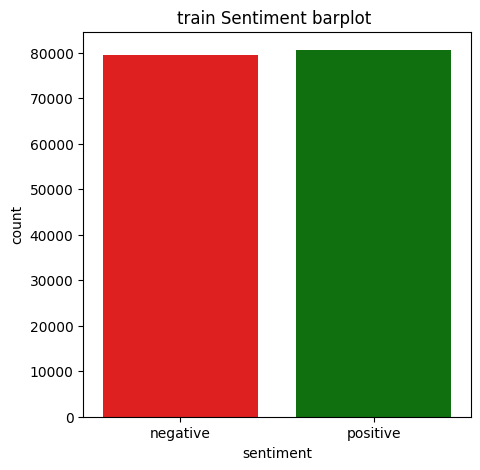

In [17]:
plot_target(metadata["train"], split = "train")

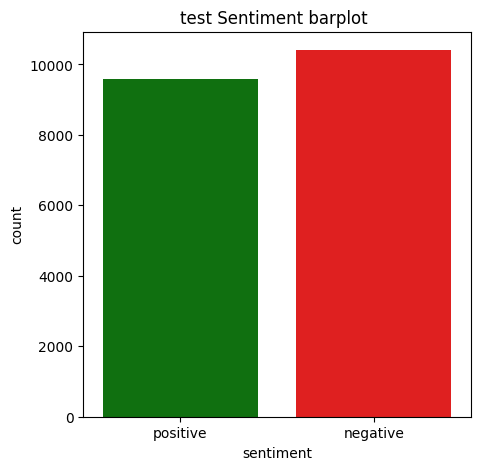

In [18]:
plot_target(metadata["test"], split = "test")

Les données semblent équilibrées que ce soit dans l'échantillon d'apprentissage ou du test.

### Visualisation des données pour vérifier la répartion de la variable cible

In [19]:
from huggingface_hub import notebook_login

notebook_login()

In [20]:
label_mapping = {
    "Negative": 0,
    "Positive": 1
}

In [21]:
from transformers import CamembertTokenizer, CamembertForSequenceClassification

tokenizer = CamembertTokenizer.from_pretrained("camembert-base")
model = CamembertForSequenceClassification.from_pretrained("camembert-base")


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
configs = {
    "model_name" : "camembert-base",
    "max_length" : 80,
    "hidden_state" : 1024,
    "train" : metadata["train"],
    "test" : metadata["test"],
    "valid" : metadata["valid"],
    "batch_size" : 32,
    "learning_rate" : 2e-5,
    "n_epochs" : 3,
    "n_classes" : 2
}

### Préparation de la Dataset pour le modèle

In [23]:
class MyDataset(Dataset):
    def __init__(self, df, tokenizer_name, max_length):
        self.df = df
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        self.max_length = max_length
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = self.df["review"].to_list()
        label = self.df["polarity"].to_list()
        inputs = self.tokenizer(
            text = text,
            max_length = self.max_length,
            padding = 'max_length',
            truncation = True,
            return_tensors = "pt"
        )


        return {
            "input_ids" : inputs["input_ids"][index],
            "attention_mask" : inputs["attention_mask"][index],
            "labels" : torch.tensor(label[index], dtype=torch.long)
        }

### Chargement sous forme de batch pour l'entrainer

In [24]:
def dataloader(dataset, batch_size, shuffle):
    return DataLoader(dataset = dataset,
                      batch_size = batch_size,
                      shuffle = shuffle
                      )

### Instanciation du modèle

In [25]:
class CustomModel(nn.Module):
    def __init__(self, model_name, n_classes):
        super(CustomModel, self).__init__()
        self.config = config = AutoConfig.from_pretrained("camembert-base", num_labels=n_classes)
        self.pretrained_model = AutoModelForSequenceClassification.from_pretrained(model_name, config = self.config)

    def forward(self, input_ids, attention_mask):
        output = self.pretrained_model(input_ids = input_ids, attention_mask = attention_mask)

        return output

### Fonction pour l'apprentissage

In [26]:
def train_step(model, train_loader, optimizer, loss_fn, device):
    model.train()

    total_loss  = 0

    for data in tqdm(train_loader, total=len(train_loader)):
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        label = data['labels'].to(device)
        #print(label)
        optimizer.zero_grad()
        output = model(input_ids = input_ids, attention_mask = attention_mask)
        loss = loss_fn(output.logits, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(train_loader)

### Fonction pour la validation

In [27]:
from sklearn.metrics import accuracy_score, classification_report

def validation_step(model, validation_loader, loss_fn, device):
    model.eval()
    predictions = []
    actual_labels = []
    valid_loss = []

    with torch.no_grad():
        for batch in validation_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)

            valid_loss.append(loss.item())

            _, preds = torch.max(outputs.logits, dim=1)

            predictions.extend(preds.cpu().tolist())

            actual_labels.extend(labels.cpu().tolist())


    accuracy = accuracy_score(actual_labels, predictions)


    return np.mean(valid_loss), accuracy

In [ ]:
## Initialisation du project dans wandb
wandb.init(project = "fr_sentiment_analysis")

## Chargement du training set
train_dataset = MyDataset(df = configs["train"],
                    tokenizer_name= configs["model_name"],
                    max_length= configs["max_length"],
                    )

## Chargement du testing set
test_dataset = MyDataset(df = configs["test"],
                    tokenizer_name= configs["model_name"],
                    max_length= configs["max_length"],
                    )

## Chargement du Training loader
train_loader = dataloader(dataset=train_dataset,
                          batch_size= configs["batch_size"],
                          shuffle=True)

## Chargement du testing loader
valid_loader = dataloader(dataset=test_dataset, batch_size= configs["batch_size"], shuffle=True)

## Paramétrage du device a "cuda" si disponible sinon à "cpu"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Instance du tokenizer
tokenizer = AutoTokenizer.from_pretrained(configs["model_name"])

## Instance de la configuration
config = AutoConfig.from_pretrained(configs["model_name"], num_labels = configs["n_classes"])

## Instance du modèle de base
model = AutoModelForSequenceClassification.from_pretrained(configs["model_name"], config=config)

model.to(device)

## Instance de la fonction de perte
loss_fn = nn.CrossEntropyLoss()

## Instance de la fonction d'optimisation
optimizer = AdamW(model.parameters(), lr = configs["learning_rate"])

## Boucle pour l'apprentissage et la validatio
for epoch in range(configs["n_epochs"]):
    loss_train = train_step(model, train_loader, optimizer, loss_fn, device)
    loss_valid, accuracy = validation_step(model = model, validation_loader = valid_loader, device=device, loss_fn=loss_fn)

    wandb.log({"loss_train":loss_train,
              "loss_valid" : loss_valid,
              "accuracy" : accuracy})


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/5000 [00:00<?, ?it/s]

In [ ]:
## Transoformation des labels sous forme de liste
labnames = list(label_mapping.keys())

# Chargement du modèle dans mon espace huggingface

repo_name = "Peed911/french_sentiment_analysis"

tokenizer.push_to_hub(repo_id = repo_name)
model.config.id2label = {str(i) : lbl for i, lbl in enumerate(labnames)}
model.config.label2id = {lbl : str(i) for i, lbl in enumerate(labnames)}
model.push_to_hub(repo_id = repo_name)